# Readme.

<p>The main goal of this algorithm is to identify a users actions within a web site(www.facebook.com). Since most sites traffic on the Internet today is encrypted using the <a href="https://en.wikipedia.org/wiki/HTTPS">HTTPS</a> protocol it is impossible to view the actual response body. A workaround the issue is to use the unencrypted traffic to identify and catch known patterens and thus infer the users actions.</p>

<p><a href="https://www.thewindowsclub.com/website-traffic-fingerprinting">Website Traffic fingerprinting</a> is a method to determine when and what a user does on the Internet. The user in question may be using a proxy or a secure tunnel VPN, encryption, etc. But still, it is possible to determine the person’s usage of Internet via snooping on the data packets traveling to and fro on the Internet.</p>

<p>Using different properties extracted from har data(for example: response body size and total request-response elapsed time) it is possible to finger print a users visit to a particular website and the actions within the site.</p>


## Csv to Dataframe

The dataset is held in 200 csv file: 100 for facebook and 100 other random sites. the first step is to extract the data from the csv files in to pandas dataframes using the Har class. A dataframe is created for each facebook and 'other' session.

In [12]:
# A list of facebook har data in pandas dataframe format.
fb_hars = Har.from_csv('./har_fit')
# A list of random urls har data in pandas dataframe format.
rnd_hars = Har.from_csv('./har_random')

In [14]:
# An example of a single facebook session har dataframe.
fb_hars[0]

,Unnamed: 0,comment,pageref,request.bodySize,request.comment,request.headersSize,request.httpVersion,request.method,request.queryString.name,request.url,...,startedDateTime,time,timings.blocked,timings.comment,timings.connect,timings.dns,timings.receive,timings.send,timings.ssl,timings.wait
0,0,NaN,facebook,0,NaN,420,HTTP/1.1,GET,NaN,https://www.facebook.com/,...,2019-10-05T09:45:01.490+03:00,2062,0,NaN,1746,76,51,3,1695,183
1,1,NaN,facebook,0,NaN,449,HTTP/1.1,GET,value,https://static.xx.fbcdn.net/rsrc.php/v3/y9/l/0...,...,2019-10-05T09:45:02.506+03:00,801,0,NaN,624,34,1,1,563,139
2,2,NaN,facebook,0,NaN,449,HTTP/1.1,GET,value,https://static.xx.fbcdn.net/rsrc.php/v3/ye/l/0...,...,2019-10-05T09:45:02.508+03:00,803,0,NaN,620,34,45,3,573,99
3,3,NaN,facebook,0,NaN,449,HTTP/1.1,GET,value,https://static.xx.fbcdn.net/rsrc.php/v3/yv/l/0...,...,2019-10-05T09:45:02.510+03:00,807,0,NaN,633,33,11,2,582,125
4,4,NaN,facebook,0,NaN,449,HTTP/1.1,GET,value,https://static.xx.fbcdn.net/rsrc.php/v3/yx/l/0...,...,2019-10-05T09:45:02.511+03:00,814,0,NaN,623,31,49,3,570,106
5,5,NaN,facebook,0,NaN,449,HTTP/1.1,GET,value,https://static.xx.fbcdn.net/rsrc.php/v3/yf/l/0...,...,2019-10-05T09:45:02.525+03:00,811,0,NaN,647,31,2,1,590,128
6,6,NaN,facebook,0,NaN,449,HTTP/1.1,GET,value,https://static.xx.fbcdn.net/rsrc.php/v3/yM/l/0...,...,2019-10-05T09:45:02.536+03:00,818,0,NaN,662,32,1,1,604,120
7,7,NaN,facebook,0,NaN,449,HTTP/1.1,GET,value,https://static.xx.fbcdn.net/rsrc.php/v3/yk/l/0...,...,2019-10-05T09:45:02.692+03:00,110,-1,NaN,-1,-1,2,0,-1,107
8,8,NaN,facebook,0,NaN,449,HTTP/1.1,GET,value,https://static.xx.fbcdn.net/rsrc.php/v3/yK/l/0...,...,2019-10-05T09:45:02.695+03:00,99,-1,NaN,-1,-1,4,0,-1,94
9,9,NaN,facebook,0,NaN,425,HTTP/1.1,GET,value,https://static.xx.fbcdn.net/rsrc.php/v3/y9/r/i...,...,2019-10-05T09:45:02.696+03:00,147,-1,NaN,-1,-1,56,0,-1,90


## Fingerprint and ResponseData
The next step is to create a fingerprint from the facebook data and responsedata objects from the 'other' urls data.
<ul>
    <li>The response.bodySize, response.headersSize and time columns are isolated</li>
    <li>For each session the response.bodySize, response.headersSize and time columns are sumed and saved in a list to use with the AumsAnalyzer.</li>
    <li>For each session in the fingerprint object weights are calculated: first all the (body size, header size, time) combinations that exist in all the rows in all the session are saved and counted.</li>
</ul>

In [53]:
# Initialize a facebook fingerprint.
fb_fp = FingerPrint(fb_hars, types=True)
# Initialize a list of 100 random urls har data.
random_rd = ResponseData(rnd_hars, types=True)

An example of the sums property of the ResponseData object.

In [16]:
random_rd.sums[:10]

[[10015624, 62896],
 [1998514, 45691],
 [216990, 8656],
 [425907, 18192],
 [2008105, 46260],
 [2306390, 4669],
 [470883, 28950],
 [32051, 1249],
 [93960, 3160],
 [925652, 29689]]

Here we can see the top 10 most common (body size, header size, time) combinations across all 100 facebook sessions.

In [17]:
fb_fp.weights.most_common(10)

[((-1, -1, 0), 697),
 ((43, 519, 99), 34),
 ((43, 519, 97), 28),
 ((43, 519, 102), 26),
 ((43, 519, 100), 26),
 ((55, 1354, 134), 26),
 ((43, 519, 98), 24),
 ((55, 1354, 132), 22),
 ((43, 519, 94), 21),
 ((43, 519, 93), 21)]

## Analyzers
<p>The last step is to create Analyzer class objects and classify the data.</p>

<p>There are 3 analyzer types: sums, weights and types.</p>

<p>SumsAnalyzer: Simply fits the sums from the fingerprint and responsedata objects to a Support vector machine model using the sklearn module.</p>

<p>WeightsAnalyzer: All rows in each responsedata session is iterated and compared with the weights in the fingerprint, if a (body size, header size, time) combination is found in the response data the number of times the combination appeares across all the fingerprints session, its weight, is added to the sessions' 'score'. The sessions 'score' is used by the WeightsAnalyzer in the classification process.</p>

<p>TypesAnalyzer: Extractes all the types in the fingerprint data and their count, uses the count to compile the fingerprint and classify.</p>

In [14]:
sa = SumsAnalyzer(fb_fp, random_rd)

In [15]:
print(classification_report(sa.y_predict_true, sa.predictions))

              precision    recall  f1-score   support

           0       0.74      0.99      0.85       624
           1       0.99      0.65      0.78       627

   micro avg       0.82      0.82      0.82      1251
   macro avg       0.86      0.82      0.81      1251
weighted avg       0.86      0.82      0.81      1251



<p>A plot showing the SumsAnalyzer data for the facebook fingerprint and all the other websites.</p>
<p>The x axis represents time and the y axis represents size.</p>

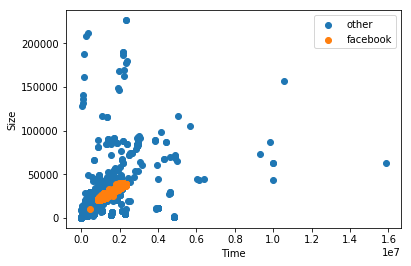

In [16]:
sa.plot_scatter()

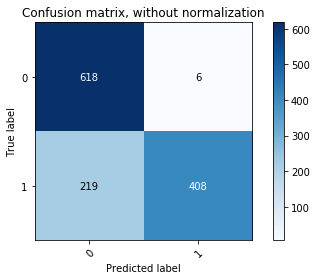

In [17]:
sa.plot_confusion_matrix()

In [ ]:
sa.pl

In [41]:
wa = WeightsAnalyzer(fb_fp, random_rd)

An example of weights: the high numbers (50 and above) are facebook sessions, the low numbers (and 0) are 'other' sites.

In [30]:
[x[0] for x in wa.x_fit[:22]]

[50, 0, 0, 0, 5, 0, 0, 1, 0, 35, 0, 50, 63, 51, 0, 0, 52, 54, 1, 1, 0, 53]

In [42]:
print(classification_report(wa.y_predict_true, wa.predictions))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       910
           1       0.97      1.00      0.99       632

   micro avg       0.99      0.99      0.99      1542
   macro avg       0.99      0.99      0.99      1542
weighted avg       0.99      0.99      0.99      1542



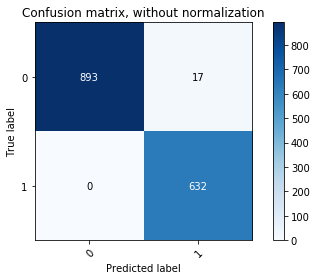

In [43]:
wa.plot_confusion_matrix()

In [44]:
ta = TypesAnalyzer(fb_fp, random_rd)

An example of the fingerprint types count for 3 sessions.

In [45]:
ta.fp.types_counts[50:53]

[{'png': 5, 'gif': 3, 'php': 1, 'js': 3, 'css': 1},
 {'png': 5, 'svg': 1, 'gif': 2, 'php': 1},
 {'png': 5, 'gif': 3, 'php': 1, 'js': 3, 'css': 1}]

A list of all the types extracted from the fingerprint data.

In [46]:
ta.fp.types

['png', 'gif', 'php', 'js', 'css', 'svg', 'net', 'com']

In [49]:
print(classification_report(ta.y_predict_true, ta.predictions))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       915
           1       0.95      0.97      0.96       627

   micro avg       0.97      0.97      0.97      1542
   macro avg       0.97      0.97      0.97      1542
weighted avg       0.97      0.97      0.97      1542



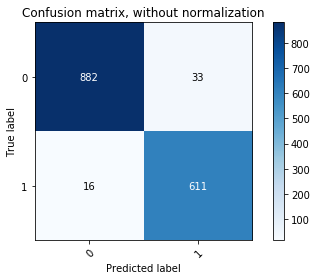

In [48]:
ta.plot_confusion_matrix()

An analyzer that combines all 3 types as features.

In [57]:
ca = CombinedAnalyzer(fb_fp, random_rd)

In [59]:
print(classification_report(ca.y_predict_true, ca.predictions))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87       623
           1       0.97      0.72      0.83       628

   micro avg       0.85      0.85      0.85      1251
   macro avg       0.88      0.85      0.85      1251
weighted avg       0.88      0.85      0.85      1251



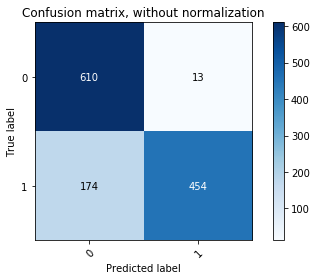

In [60]:
ca.plot_confusion_matrix()

# Code
## Imports

In [3]:
import json
import re
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import selenium
import iplantuml
from abc import ABC, abstractclassmethod
from seleniumwire import webdriver
from browsermobproxy import Server
from collections import Counter
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction import DictVectorizer

ImportError: No module named matplotlib.pyplot

## Class Har
<p>Mainly used to get the session data from a csv file and convert it to a pandas dataframe.</p>
<p>Has 2 static functions for data gathering: one to get the HAR file from the browser and one to gather the data from a csv file.</p>

In [2]:
class Har:
    @staticmethod
    def from_csv(path: str) -> list:
        """
        Transform each har_fit file in the path to a Pandas DataFrame,
        add each DataFrame to a list,
        and return the list.

        :param str path: The path to the har_fit files directory.
        :return list: A list of the har_fit files data in Pandas DataFrames.
        """

        hars = []

        for file in os.listdir(path):
            if file[-4:] == '.csv':
                hars.append(pd.read_csv(f'{path}/{file}'))

        return hars


    @staticmethod
    def capture_n_har_files(path: str, n: int = 1, name: str = '', url: str = '', rnd: bool = False):
        """
        Run n times:
         Create an Har class instance.
         Using BrowsermobProxy start recording har_fit data.
         Using selenium start a browser and go to the url.
         Create a Pandas DataFrame from the har_fit data recorded.
         Close the selenium session and the proxy.
         Export the DataFrame to a csv file.

        :param path: csv file/s save location.
        :param rnd: Whether to choose a random url.
        :param n: Number of times to run.
        :param name: Record name.
        :param url: The web site, use full address(exm: http://www.google.com).
        """

        urls = ['https://findtheinvisiblecow.com/', 'https://theuselessweb.com/', 'http://hackertyper.com/',
                'https://www.pointerpointer.com/', 'http://www.staggeringbeauty.com/', 'http://beesbeesbees.com/',
                'http://www.shadyurl.com/', 'http://dontevenreply.com/', 'http://www.shutupandtakemymoney.com/',
                'https://en.wikipedia.org/wiki/List_of_individual_dogs', 'http://www.drivemeinsane.com/',
                'https://apod.nasa.gov/apod/astropix.html', 'https://www.duolingo.com/', 'http://hubski.com/',
                'https://lizardpoint.com/', 'https://www.musictheory.net/', 'https://sleepyti.me/',
                'https://www.codecademy.com/', 'https://www.whatshouldireadnext.com/', 'https://www.onread.com/',
                'http://weavesilk.com/', 'https://www.ineedaprompt.com/', 'https://thisissand.com/',
                'https://pokemonshowdown.com/', 'https://snes.party/', 'https://www.sporcle.com/',
                'https://www.poptropica.com/', 'https://koalabeast.com/',
                'http://orteil.dashnet.org/cookieclicker/',
                'http://www.foddy.net/2010/10/qwop/', 'https://habitrpg.com/static/front',
                'http://www.flashbynight.com/',
                'http://www.partycloud.fm/', 'http://youarelistening.to/', 'https://www.incredibox.com/',
                'https://asoftmurmur.com/', 'https://www.rainymood.com/', 'http://ww7.good-v-evil.com/',
                'https://beta.freerice.com/#/english-vocabulary/1381', 'http://www.facebook.com']
        try:
            last_i = int(max(re.findall('\\d+', os.listdir('./har_fit').__str__())))
        except ValueError:
            last_i = -1

        for i in range(last_i + 1, last_i + 1 + n):
            if rnd:
                url = urls[random.randrange(len(urls))]

            print(str(last_i + 1 + i) + ' ' + url)

            har = Har()
            har.capture_url_har_data(name, url)
            har.build_df()
            har.quit()

            har.export_df(f'{path}/har_df_{i}.csv')


    def __init__(self, path=None):
        if path is None:
            self.server = Server(
                'C:/Users/Geco/AngularProjects/BuildUrlDatabase/py/browsermob-proxy-2.1.4/bin/browsermob-proxy.bat')
            self.server.start()

            run = True
            while run:
                try:
                    self.proxy = self.server.create_proxy()
                    run = False
                except requests.exceptions.ConnectionError as e:
                    print(e)

            self.driver = self._start_chrome_driver()
            self.df = None
            self.server.start()
        else:
            self.df = pd.read_csv(f'{path}')


    def _start_chrome_driver(self) -> webdriver:
        """
        Using Selenium start the google chrome browser headless.
        All the browser requests and responses(har_fit data) will be recorded
        using a BrowsermobProxy proxy server.

        :return: Google chrome driver object.
        """

        chrome_options = webdriver.ChromeOptions()
        chrome_options.set_capability('proxy', {'httpProxy': f'{self.proxy.proxy}',
                                                'noProxy': '',
                                                'proxyType': 'manual',
                                                'sslProxy': f'{self.proxy.proxy}'})
        chrome_options.add_argument("--headless")

        driver = webdriver.Chrome(chrome_options=chrome_options)
        driver.set_page_load_timeout(10)
        return driver


    def capture_url_har_data(self, name: str, url: str):
        """
        Start recording the HAR data via proxy.
        :param name: Recording name.
        :param url: Full website name(exm: http://www.google.com).
        """
        self.proxy.new_har(name)

        try:
            self.driver.get(url)
        except selenium.common.exceptions.TimeoutException as e:
            print(e)


    def quit(self):
        """
        Close all open connections:
        Close the proxy server and the chrome driver.
        """
        self.driver.quit()
        self.server.stop()
        os.system("taskkill /f /im java.exe")


    def export_har(self):
        """
        Export the har_fit recording to a json file.
        """
        with open('./har_fit.json', 'w') as file:
            json.dump(self.proxy.har, file)


    def export_df(self, path):
        """
        Export the instance DataFrame to a csv file.
        :param path: Export directory path.
        """
        self.df.to_csv(path)


    def _add_to_dict(self, __, k, v):
        """
        Utility method for the build_df method.
        """
        if type(v) == list:
            for kk, vv in v:
                if type(vv) == dict or type(vv) == list:
                    self._add_to_dict(__, k + kk + '.', vv)
                else:
                    __[k + kk] = vv
        else:
            for kk, vv in v.items():
                if type(vv) == dict or type(vv) == list:
                    self._add_to_dict(__, k + kk + '.', vv)
                else:
                    __[k + kk] = vv


    def build_df(self):
        """
        Iterate each row in the har_fit data csv file
        and add it to a dictionary.
        Add all the rows dictionaries to a list.
        Create one complete DataFrame from the list.

        :return: The instance har_fit recording data in the form of a Pandas DataFrame.
        """
        _ = list()

        for entry in self.proxy.har['log']['entries']:
            __ = dict()

            for k, v in entry.items():
                if type(v) == dict or type(v) == list:
                    self._add_to_dict(__, k + '.', v)
                else:
                    __[k] = v

            _.append(__)

        self.df = pd.DataFrame(_)

## Class Fingerprint
<p>Stores the finger print information for a website and all the preprocess data nedded for analysis.</p>

In [3]:
class FingerPrint:
    def __init__(self, hars, types: bool = False):
        self.hars = hars
        self.length = len(hars)
        self.sums = []
        self.sessions = []
        self.weights = None

        self._init_data()
        self._init_weights()

        if types:
            self.types_counts = self._gather_types()
            self.types = self._get_types()


    def _gather_types(self):
        _ = []

        for df in self.hars:
            __ = {}

            for row in df.iterrows():
                try:
                    ___ = re.findall('(?<=\.)\w{1,4}$', row[1]['request.url'])[0]

                    if ___ in __:
                        __[___] += 1
                    else:
                        __[___] = 1
                except IndexError:
                    pass

            _.append(__)

        return _


    def _get_types(self):
        _ = []

        for session in self.types_counts:
            for k in session.keys():
                if k not in _:
                    _.append(k)

        return _


    def _init_data(self):
        for har in self.hars:
            session_sums = [0, 0]
            session = []

            for row in har[['response.bodySize', 'response.headersSize', 'time']].values:
                row = tuple(row.tolist())

                # Add to sums.
                session_sums[0] += row[0]
                session_sums[1] += row[1]

                session.append(row)

            # Add to count.
            self.sessions.append(session)
            self.sums.append(session_sums)


    def _flatten_sessions(self):
        return [row for session in self.sessions for row in session]


    def _init_weights(self):
        flat_sessions = self._flatten_sessions()
        self.weights = Counter(flat_sessions)

## Class ResponseData
<p>Hold the data required for analysis for a single url.</p>

In [52]:
class ResponseData:
    def __init__(self, hars: list, types: bool=False):
        self.hars = hars
        self.length = len(self.hars)
        self.sums = []
        self.sessions = []

        self._init_data()

        if types:
            self.types_counts = self._gather_types()


    def _init_data(self):
        """Sum body size and header size individually for each session: (body size, header size)
           Create a tuple of (body size, header size) per session then add each session to self.sessions."""
        for har in self.hars:
            session_sums = [0, 0]
            session = []

            for row in har[['response.bodySize', 'response.headersSize', 'time']].values:
                row = tuple(row.tolist())

                session_sums[0] += row[0]
                session_sums[1] += row[1]

                session.append(row)

            self.sums.append(session_sums)
            self.sessions.append(session)


    def _gather_types(self):
        _ = []

        for df in self.hars:
            __ = {}

            for row in df.iterrows():
                try:
                    ___ = re.findall('(?<=\.)\w{1,4}$', row[1]['request.url'])[0]

                    if ___ in __:
                        __[___] += 1
                    else:
                        __[___] = 1
                except IndexError:
                    pass

            _.append(__)

        return _


## Class Analyzer
<p>An abstract class for all analyzers.</p>

In [2]:
class Analyzer:
    def __init__(self, fp: FingerPrint, rd: ResponseData):
        self.fp = fp  # Fit data.
        self.rd = rd  # Predict data.
        self.x_fit = []
        self.x_predict = []
        self.y_fit_true = []
        self.y_predict_true = []


        def plot_confusion_matrix(self, title=None, cmap=plt.cm.Blues):
        """This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """

        # Compute confusion matrix
        cm = confusion_matrix(self.y_predict_true, self.predictions)
        # Only use the labels that appear in the data
        classes = unique_labels(self.y_fit_true, self.y_predict_true)

        print(classification_report(self.y_predict_true, self.predictions, labels=[0, 1],
                                    target_names=['facebook', 'other']))

        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', extent=[-.5, cm.shape[1] - .5, -.5, cm.shape[1] - .5], cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.flip(np.arange(cm.shape[0])),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), ha="center")
        plt.setp(ax.get_yticklabels(), va="center")

        # Loop over data dimensions and create text annotations.
        thresh = cm.max() / 2.

        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[cm.shape[1] - i - 1, j], 'd'), ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

        fig.tight_layout()


    def plot_roc_auc(self):
        y_score = self.clf.decision_function(self.x_predict)

        fpr, tpr, _ = roc_curve(self.y_predict_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure()

        plt.plot(fpr, tpr, lw=2, label=f'AUC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], lw=1, color='k', linestyle='-')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")

        plt.show()

SyntaxError: invalid syntax (<ipython-input-2-f6bdea46103c>, line 2)

## Class  WeightsAnalyzer
<p>Holds all the data nedded for preprocess and classification using the weights method.</p>

In [40]:
class WeightsAnalyzer(Analyzer):
    def __init__(self, fp: FingerPrint, rd: ResponseData):
        super().__init__(fp, rd)

        self._init_data()
        self.clf = self._classify()
        self.predictions = self.clf.predict(self.x_predict)

        self.score = cross_val_score(self.clf, self.x_fit, y=self.y_fit_true, cv=5, scoring='f1_weighted')


    def _score_sessions(self, sessions: list, label: int):
        _ = []
        __ = []

        for session in sessions:
            session_score = 0

            for feature in self.fp.weights.keys():
                if feature in session:
                    session_score += 1

            _.append([session_score])
            __.append(label)

        return np.array(_), np.array(__)


    def _init_data(self):
        self.x_fit, self.y_fit_true = self._score_sessions(self.fp.sessions, 1)
        self.x_predict, self.y_predict_true = self._score_sessions(self.rd.sessions, 0)


    def _classify(self):
        self.x_fit, self.x_predict, self.y_fit_true, self.y_predict_true = train_test_split(
            np.concatenate([self.x_fit, self.x_predict]), np.concatenate([self.y_fit_true, self.y_predict_true]),
            test_size=0.9)

        return svm.SVC(gamma='scale', kernel='rbf').fit(self.x_fit, self.y_fit_true)

## Class  SumsAnalyzer
<p>Holds all the data nedded for preprocess and classification using the sums method.</p>

In [7]:
class SumsAnalyzer(Analyzer):
    def __init__(self, fp: FingerPrint, rd: ResponseData):
        super().__init__(fp, rd)

        self._init_data()
        self.clf = self._classify()
        self.predictions = self.clf.predict(self.x_predict)

        self.score = cross_val_score(self.clf, self.x_fit, y=self.y_fit_true, cv=5, scoring='f1_weighted')


    def _init_data(self):
        length = min(len(self.fp.hars), len(self.rd.hars))

        self.x_fit, self.x_predict, self.y_fit_true, self.y_predict_true = train_test_split(
            np.concatenate([self.fp.sums[:length], self.rd.sums[:length]]), [1] * length + [0] * length, test_size=0.9)


    def _classify(self):
        return svm.SVC(gamma='scale', kernel='rbf').fit(self.x_fit, self.y_fit_true)
    
    def plot_scatter(self):
        x_fp = np.array(self.fp.sums)[:, 0]
        y_fp = np.array(self.fp.sums)[:, 1]

        x_rd = np.array(self.rd.sums)[:, 0]
        y_rd = np.array(self.rd.sums)[:, 1]

        plt.scatter(x_rd, y_rd, label='other')
        plt.scatter(x_fp, y_fp, label='facebook')
        plt.legend()
        plt.ylabel('Size')
        plt.xlabel('Time')

## Class  TypesAnalyzer
<p>Holds all the data nedded for preprocess and classification using file type.</p>

In [8]:
class TypesAnalyzer(Analyzer):
    def __init__(self, fp: FingerPrint, rd: ResponseData):
        super().__init__(fp, rd)

        self.dict_vectorizer = DictVectorizer(sparse=False)
        self._init_data()
        self.clf = self._classify()
        self.predictions = self.clf.predict(self.x_predict)


    def _init_data(self):
        _ = []

        for session_types in self.rd.types_counts:
            __ = {}

            for t in self.fp.types:
                if t in session_types:
                    __[t] = session_types[t]
                else:
                    __[t] = 0

            _.append(__)

        self.x_fit = self.dict_vectorizer.fit_transform(self.fp.types_counts)
        self.y_fit_true = [1] * self.x_fit.shape[0]
        self.x_predict = self.dict_vectorizer.transform(_)
        self.y_predict_true = [0] * self.x_predict.shape[0]


    def _classify(self):
        self.x_fit, self.x_predict, self.y_fit_true, self.y_predict_true = train_test_split(
            np.concatenate([self.x_fit.data, self.x_predict.data]),
            np.concatenate([self.y_fit_true, self.y_predict_true]),
            test_size=0.9)

        return svm.SVC(gamma='scale', kernel='rbf').fit(self.x_fit, self.y_fit_true)


## Class  CombinedAnalyzer
<p>Holds all the data nedded for preprocess and classification using file type, sums and weights.</p>

In [56]:
class CombinedAnalyzer(Analyzer):
    def __init__(self, fp: FingerPrint, rd: ResponseData):
        super().__init__(fp, rd)

        self.dict_vectorizer = DictVectorizer(sparse=False)
        self._init_data()
        self.clf = self._classify()
        self.predictions = self.clf.predict(self.x_predict)

        self.score = cross_val_score(self.clf, self.x_fit, y=self.y_fit_true, cv=5, scoring='f1_weighted')


    def _init_data(self):
        length = min(self.fp.length, self.rd.length)

        # Add the type feature.
        self.x_fit = self.dict_vectorizer.fit_transform(self.fp.types_counts[:length]).tolist()
        self.x_predict = self.dict_vectorizer.transform(self.rd.types_counts[:length]).tolist()

        for session_i in range(length):
            # Add the sums feature.
            self._add_sums(session_i)

            # Add the weight score. 0 by default.
            self.x_fit[session_i].append(0)
            self.x_predict[session_i].append(0)

            # Add the weights feature.
            self._add_weights(session_i)

            # Add labels
            self.y_fit_true.append(1)
            self.y_predict_true.append(0)


    def _add_sums(self, i):
        self.x_fit[i].append(self.fp.sums[i][0])
        self.x_fit[i].append(self.fp.sums[i][1])
        self.x_predict[i].append(self.rd.sums[i][0])
        self.x_predict[i].append(self.rd.sums[i][1])


    def _add_weights(self, i):
        for feature in self.fp.weights.keys():
            if feature in self.fp.sessions[i]:
                self.x_fit[i][-1] += 1
            if feature in self.rd.sessions[i]:
                self.x_predict[i][-1] += 1


    def _classify(self):
        self.x_fit, self.x_predict, self.y_fit_true, self.y_predict_true = train_test_split(
            np.concatenate([self.x_fit, self.x_predict]), np.concatenate([self.y_fit_true, self.y_predict_true]),
            test_size=0.9)

        return svm.SVC(gamma='scale', kernel='rbf').fit(self.x_fit, self.y_fit_true)